# World Happiness – Regional Interpretation of Well-Being
**Student:** Bakhtiyor Sohibnazarov  
**Student Number:** Z22590018  
**Module:** Data Visualization   
**Date Updated:** December 23, 2025

## 1. Importing Libraries
Section installs and imports required libraries used in this notebook    
It will also import and display first few rows of raw dataset for inspection


In [47]:
# Run this block to install required libraries if missing.
!pip install pandas numpy matplotlib seaborn scikit-learn

In [48]:
# Importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

custom_cb_palette = [
    "#E69F00",  # orange (accent)
    "#009E73",  # green
    "#CC79A7",  # purple
    "#D55E00",  # red-brown (safe, not pure red)
    "#F0E442",  # yellow
    "#56B4E9",  # light blue (de-emphasised)
    "#999999"   # grey
]

sns.set_theme(
    style="whitegrid",
    palette=custom_cb_palette,
    context="notebook"
)

# Load initial dataset
df = pd.read_csv("dataset/raw/world-happiness-report.csv")
df.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258
1,Afghanistan,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237
2,Afghanistan,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275
3,Afghanistan,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267
4,Afghanistan,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268


## 2. Data Preparation
### Cleanup

This section performs light cleaning and ensures that key variables are available in a consistent format.   
Rename cols for easier analysis. We will note use Postive and Negative affect cols so its best to remove them from dataset we are analyzing

In [49]:
# Rename original colonumns with given new names
df = df.rename(columns={
    "Country name": "Country",
    "year": "Year",
    "Life Ladder": "Happiness",
    "Log GDP per capita": "GDP",
    "Social support": "SocialSupport",
    "Healthy life expectancy at birth": "Health",
    "Freedom to make life choices": "Freedom",
    "Perceptions of corruption": "Corruption"
})

# Drop cols
df = df.drop(columns=["Positive affect", "Negative affect"], errors="ignore")
df.head()

,Country,Year,Happiness,GDP,SocialSupport,Health,Freedom,Generosity,Corruption
0,Afghanistan,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882
1,Afghanistan,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850
2,Afghanistan,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707
3,Afghanistan,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731
4,Afghanistan,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776


### Year Continuity Check
As the dataset contains country-level observations across multiple years, an assessment of year continuity was conducted before further analysis. This step ensures that differences in temporal coverage do not introduce bias into the analytical pipeline.

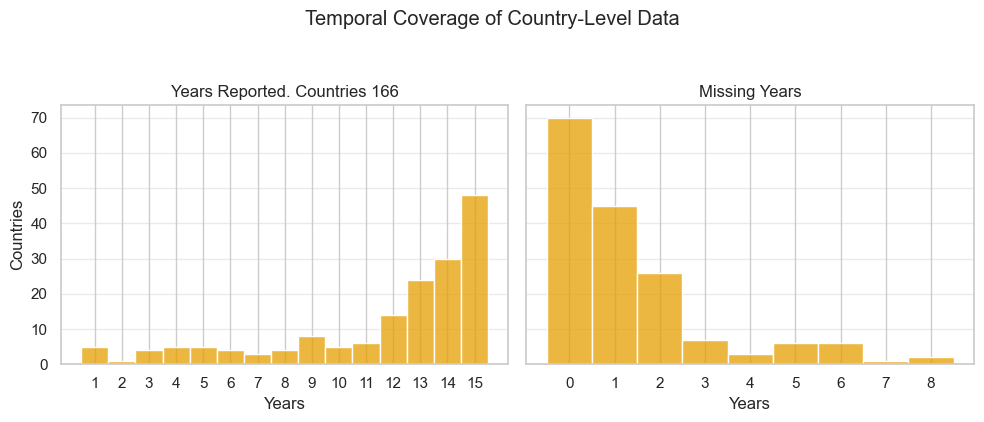

In [50]:
coverage = (
    df.groupby("Country")["Year"]
      .agg(YearsReported="nunique", YearMin="min", YearMax="max")
      .assign(
          MissingYears=lambda x: (x["YearMax"] - x["YearMin"] + 1) - x["YearsReported"]))

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Years Reported
sns.histplot(coverage["YearsReported"], discrete=True, ax=axes[0])

axes[0].set_title(f"Years Reported. Countries {len(coverage)}")
axes[0].set_xlabel("Years")
axes[0].set_ylabel("Countries")
axes[0].set_xticks(range(coverage["YearsReported"].min(), coverage["YearsReported"].max() + 1))
axes[0].grid(True, axis="y", alpha=0.4)

# Missing Years
sns.histplot(coverage["MissingYears"], discrete=True, ax=axes[1])

axes[1].set_title("Missing Years")
axes[1].set_xlabel("Years")
axes[1].set_xticks(range(coverage["MissingYears"].min(), coverage["MissingYears"].max() + 1))
axes[1].grid(True, axis="y", alpha=0.4)

# Finalise
plt.suptitle("Temporal Coverage of Country-Level Data", y=1.05)
plt.tight_layout()
plt.savefig("country_year_coverage_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

### Consistency Filtering
Countries were evaluated based on the number of years reported. Only those with a minimum of three consecutive years were retained for analysis, ensuring sufficient temporal continuity and minimising bias introduced by inconsistent reporting.

In [51]:
MIN_YEARS = 3
years = np.sort(df["Year"].unique())

# Optimal contiguous window
windows = [(years[i], years[i + MIN_YEARS - 1])
           for i in range(len(years) - MIN_YEARS + 1)]

best_start, best_end = max(
    windows,
    key=lambda w: df[
        df["Year"].between(*w)
    ].groupby("Country")["Year"].nunique().ge(MIN_YEARS).sum()
)

# Lock window & enforce consistency
df_window = df[df["Year"].between(best_start, best_end)]
df_balanced = df_window.groupby("Country").filter(
    lambda x: x["Year"].nunique() >= MIN_YEARS
)

# Summary
print(f"Best window: {best_start}–{best_end}")

Best window: 2015–2017


## Interpolation
### Check missing data
We need to check if there is missing cells in the balanced dataset and interpolate where it is possible

In [52]:
# Check missing data by grouping
missing_by_country_var = (df_balanced.set_index(["Country", "Year"]).isna().groupby("Country").sum())

# Display
missing_by_country_var[missing_by_country_var.sum(axis=1) > 0]

,Happiness,GDP,SocialSupport,Health,Freedom,Generosity,Corruption
Country,,,,,,,
Bahrain,0,0,0,0,0,0,3
China,0,0,0,0,2,0,3
Egypt,0,0,0,0,0,0,1
Jordan,0,0,0,0,0,0,3
Kosovo,0,0,0,3,0,0,0
Kuwait,0,0,0,0,0,0,3
Libya,0,0,0,0,0,0,2
Palestinian Territories,0,0,0,3,0,0,0
Saudi Arabia,0,0,0,0,0,0,3


### Further Cleaning and Interpolation
Extreme missingness cannot be filled further, fabricated data will corrupt dataset. Remaining NaNs should be handled during analysis but extreme missingness should be removed in order to make dataset as much clean as possible. Therefore Corruption col and South Sudan can be removed to minimize missing data and stabilize GDP col respectively

In [53]:
# Remove country with structural GDP/Generosity gaps
df_balanced = df_balanced[df_balanced["Country"] != "South Sudan"].copy()

# Drop corruption due to systemic regional missingness
df_balanced = df_balanced.drop(columns=["Corruption"], errors="ignore")

num_cols = ["GDP", "SocialSupport", "Health", "Freedom", "Generosity"]

# Within-country interpolation (time-aware) WITHOUT groupby.apply (no FutureWarning)
df_balanced = df_balanced.sort_values(["Country", "Year"]).reset_index(drop=True)
df_balanced[num_cols] = (
    df_balanced.groupby("Country")[num_cols]
    .transform(lambda s: s.interpolate(method="linear", limit_direction="both"))
)

countries_original = set(df["Country"].unique())
countries_final = set(df_balanced["Country"].unique())

# Countries excluded by temporal consistency or cleaning
excluded_countries = countries_original - countries_final
df_excluded = df[df["Country"].isin(excluded_countries)].copy()

# Save Excluded countries
df_excluded.to_csv("dataset/output/excluded.csv", index=False)

# Save final file
df_balanced.to_csv("dataset/output/world_happiness_final.csv", index=False)

# Final summary
print("=== Final Dataset Summary ===")
print(f"Countries before preprocessing: {len(countries_original)}")
print(f"Countries after preprocessing:  {len(countries_final)}")
print(f"Excluded Countries {len(excluded_countries)} countries")
print(f"\nFinal dataset saved successfully...")

# Remaining missingness check (diagnostic only)
missing_by_country = df_balanced.isna().groupby(df_balanced["Country"]).sum()
missing_by_country[missing_by_country.sum(axis=1) > 0]

=== Final Dataset Summary ===
Countries before preprocessing: 166
Countries after preprocessing:  134
Excluded Countries 32 countries

Final dataset saved successfully...


,Country,Year,Happiness,GDP,SocialSupport,Health,Freedom,Generosity
Country,,,,,,,,
Kosovo,0,0,0,0,0,3,0,0
Palestinian Territories,0,0,0,0,0,3,0,0
Taiwan Province of China,0,0,0,0,0,3,0,0


## 3. Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) was conducted to develop an initial understanding of the structure, behaviour, and relationships within the preprocessed World Happiness dataset. The purpose of this stage is not to test hypotheses or draw causal conclusions, but to identify patterns, distributions, and associations that can inform meaningful and data-driven research questions.

### Univariate Exploration

Univariate exploration examines each variable independently in order to understand its distributional characteristics across countries. This step focuses on identifying skewness, concentration, spread, and potential irregularities without considering relationships between variables.

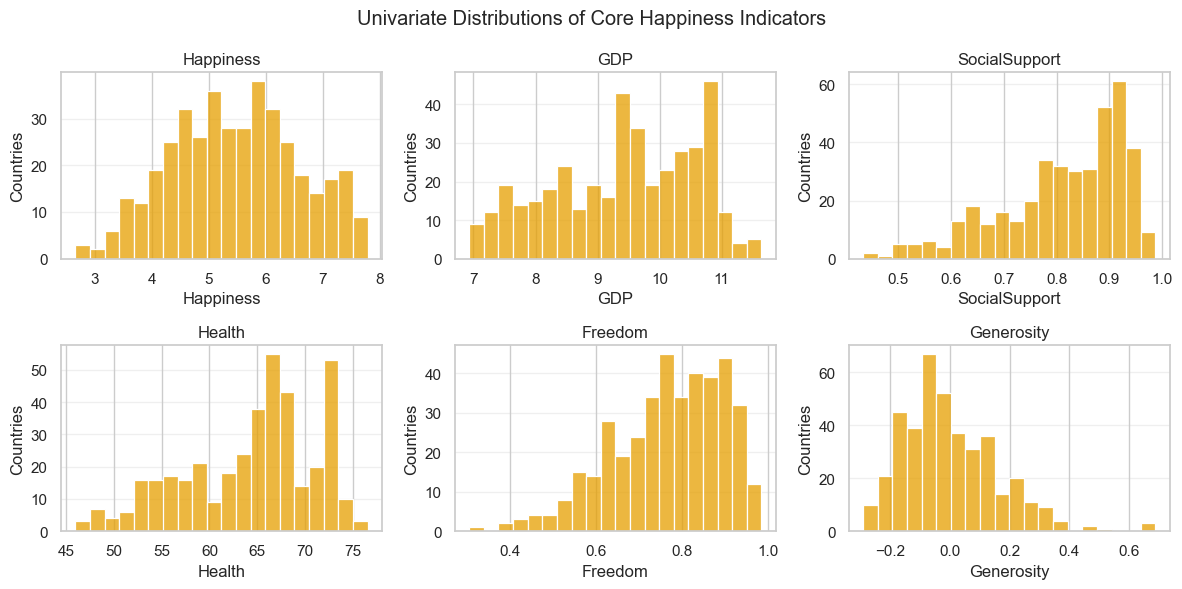

In [54]:
# Define Cols for analysis
univariate_cols = [
    "Happiness",
    "GDP",
    "SocialSupport",
    "Health",
    "Freedom",
    "Generosity"]

# Create plot
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for ax, col in zip(axes, univariate_cols):
    sns.histplot(
        df_balanced[col],
        bins=20,
        ax=ax
    )
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("Countries")
    ax.grid(True, axis="y", alpha=0.3)

# Finalize
plt.suptitle("Univariate Distributions of Core Happiness Indicators")
plt.tight_layout()
plt.savefig(f"assets/eda/univariate_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

#### Univariate Analysis Assumptions

Univariate analysis treats each indicator independently and does not account for interactions between variables or contextual differences across countries. The observed distributions reflect country-level averages derived from survey data and may mask within-country variation.


### Bivariate Exploration Refinement

Following univariate analysis, bivariate exploration is refined to examine how national happiness relates to each contributing indicator in greater detail. This stage focuses on clarifying the form, strength, and variability of associations observed during initial exploration.

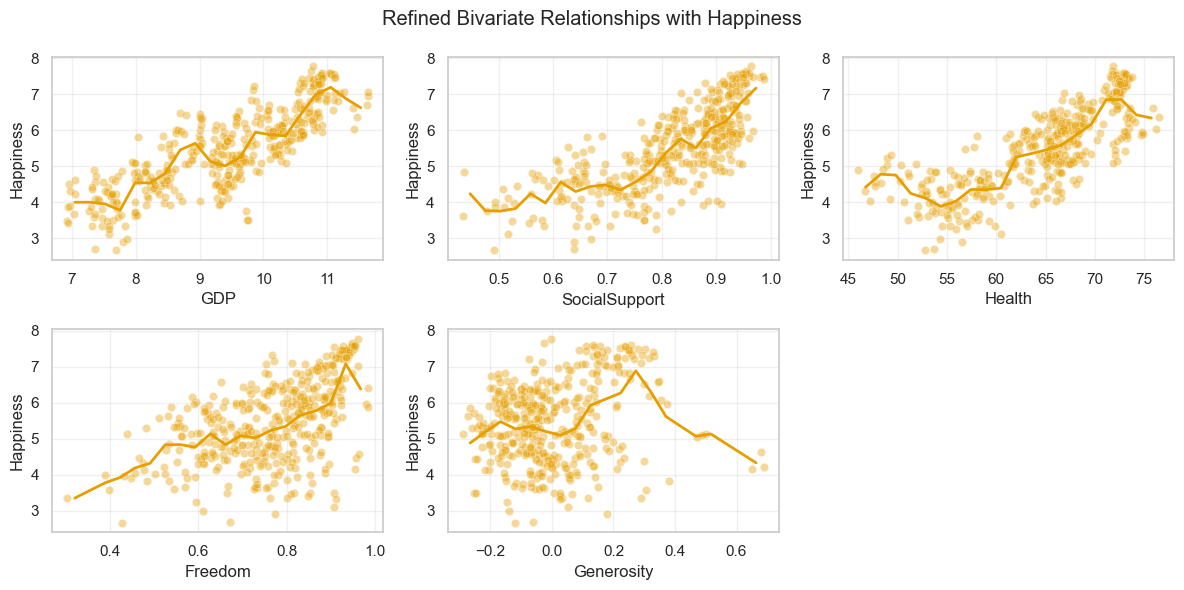

In [55]:
# Define cols
bivariate_cols = [
    "GDP",
    "SocialSupport",
    "Health",
    "Freedom",
    "Generosity"
]

# Define plot axes
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

# For results averages
N_BINS = 20


for ax, col in zip(axes, bivariate_cols):
    # Scatter: raw data
    sns.scatterplot(
        x=df_balanced[col],
        y=df_balanced["Happiness"],
        ax=ax,
        alpha=0.4
    )

    # Bin x and compute mean happiness per bin
    bins = pd.cut(df_balanced[col], bins=N_BINS)
    bin_means = (
        df_balanced
        .groupby(bins, observed=True)["Happiness"]
        .mean()
        .dropna()
    )

    # Bin centres for plotting
    x_centres = [interval.mid for interval in bin_means.index]

    ax.plot(
        x_centres,
        bin_means.values,
        linewidth=2)

    ax.set_xlabel(col)
    ax.set_ylabel("Happiness")
    ax.grid(True, alpha=0.3)

# Remove unused subplot
fig.delaxes(axes[-1])

plt.suptitle("Refined Bivariate Relationships with Happiness")
plt.tight_layout()
plt.savefig(f"assets/eda/bivariate_distribution.png",dpi=300,bbox_inches="tight")
plt.show()


### Key Bivariate Observations

Refined bivariate exploration reveals that while GDP, social support, health, and freedom are positively associated with happiness, these relationships differ in shape and consistency. GDP and health exhibit diminishing returns, with happiness gains flattening at higher levels. Social support shows the most stable and tightly clustered association with happiness across countries.

Freedom displays a positive but highly dispersed relationship, indicating that countries with similar freedom levels may experience different happiness outcomes. Generosity shows weak and unstable association with happiness, suggesting limited explanatory power at the national level.

The observed dispersion and non-linearity across indicators indicate that structural factors alone do not fully account for differences in happiness, motivating further investigation into regional and contextual influences.


### Multivariate Analysis

Multivariate analysis is used to examine how multiple indicators jointly relate to national happiness and to each other. Unlike bivariate exploration, which considers variables in isolation, this stage focuses on the combined structure of economic, social, and institutional factors.

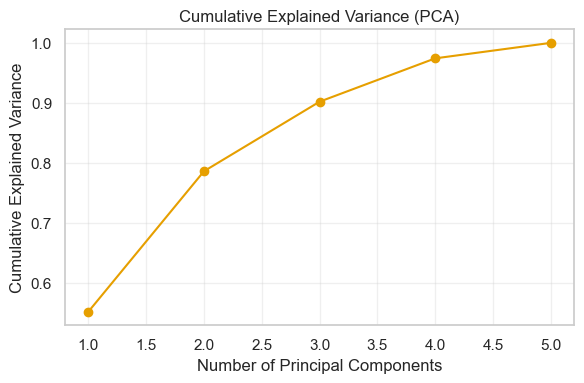

,PC1,PC2,PC3,PC4,PC5
GDP,0.549961,-0.217152,-0.129716,-0.281333,0.744589
SocialSupport,0.511202,-0.108008,-0.168898,0.826145,-0.126354
Health,0.542848,-0.190415,-0.096193,-0.480617,-0.654838
Freedom,0.354806,0.497766,0.790943,0.011067,0.025078
Generosity,0.125079,0.810648,-0.565512,-0.084977,0.013407


In [56]:
# Define features
features = [
    "GDP",
    "SocialSupport",
    "Health",
    "Freedom",
    "Generosity"
]

# PCA-specific clean subset (listwise deletion)
df_pca = df_balanced[features].dropna()

# Standardise features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pca)

# Fit PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Plot cumulative explained variance
plt.figure(figsize=(6, 4))
plt.plot(
    range(1, len(explained_variance) + 1),
    explained_variance.cumsum(),
    marker="o"
)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance (PCA)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# PCA Loadings (component interpretation)
loadings = pd.DataFrame(
    pca.components_.T,
    index=features,
    columns=[f"PC{i+1}" for i in range(len(features))]
)

loadings

The PCA loadings indicate that the first principal component is dominated by GDP, health, and social support, representing a general socio-economic well-being dimension. Subsequent components reflect additional variation associated with freedom and generosity, suggesting that beyond material conditions, countries differ in value-oriented and institutional characteristics. This supports the view that happiness reflects both structural conditions and contextual interpretation, motivating regional comparison.

#### EDA Synthesis: Key Tensions Motivating the Research Questions

The following tensions emerged directly from the exploratory analysis and motivated the formulation of the research questions:

- **Strong overall structure, but clear unexplained variation**  
  In the bivariate plots of happiness against GDP, health, and social support (Section 3.6), clear positive trends were visible. However, these same plots showed large vertical spreads, meaning that countries with similar structural conditions often reported very different happiness levels. This indicates that economic and social indicators explain part, but not all, of the variation in happiness.

- **Stable relationships for some indicators, unstable for others**  
  The bivariate analysis showed that social support had a relatively tight and consistent relationship with happiness, while freedom and generosity displayed much noisier and more dispersed patterns. This contrast, visible across multiple bivariate plots, suggests that some indicators behave consistently across countries, while others may depend more on context or interpretation.

- **One dominant pattern, plus additional meaningful differences**  
  Multivariate analysis using PCA (Section 3.9) showed that a single principal component, dominated by GDP, health, and social support, explained a large proportion of the variance. At the same time, secondary components associated with freedom and generosity captured additional structure. This indicates that happiness is shaped by a shared baseline of material and social conditions, alongside other factors that vary across countries.

- **Similar conditions do not guarantee similar outcomes**  
  Across both bivariate plots and the PCA results, countries with comparable positions along the main socio-economic dimension still differed noticeably in reported happiness. This recurring pattern suggests that differences in happiness are not solely driven by measurable structural inputs.

- **Common measurement, potentially different interpretation**  
  Although happiness is measured using the same survey framework for all countries, the dispersion observed in bivariate plots and the presence of secondary PCA dimensions suggest that happiness may be interpreted or reported differently across groups of countries.

Taken together, these findings indicate that while structural factors provide an important baseline for happiness, they do not fully explain cross-country differences. This directly motivates a regional perspective, examining whether countries within similar geographic or regional contexts show comparable happiness patterns and whether relationships between happiness and its contributing factors vary by region.


## 4. Research Questions

The exploratory data analysis showed that happiness is strongly related to economic and social conditions such as GDP, health, and social support. However, the analysis also revealed clear limitations to these explanations. Across the bivariate plots, countries with similar structural conditions often reported very different happiness levels, and multivariate analysis showed that not all variation in happiness is captured by a single socio-economic dimension.

These patterns suggest that structural indicators alone do not fully explain how happiness is reported. In particular, the remaining variation and dispersion observed in the EDA point toward contextual influences, such as geographic or regional background, which may shape how happiness is experienced or reported. To examine these issues more directly, the following research questions are defined.

### RQ1  
**Do countries within similar geographic or regional contexts exhibit comparable happiness reporting patterns, beyond what is explained by economic and social indicators?**

This question builds on the observed dispersion in happiness among countries with similar GDP, health, and social support levels. It investigates whether countries within the same region tend to cluster together in terms of reported happiness, suggesting a shared contextual or regional influence beyond structural conditions.

---

### RQ2  
**Do the relationships between happiness and key indicators (e.g. GDP, social support, health) differ systematically across regions?**

Bivariate analysis showed that while several indicators are positively related to happiness, the strength and consistency of these relationships vary. This question examines whether different regions place different weight on economic, social, or institutional factors when it comes to happiness, as reflected in region-specific relationship patterns.

---

### RQ3  
**Do some regions report higher or lower happiness than their structural conditions would suggest?**

This question focuses on whether certain regions systematically deviate from expected happiness levels given their economic and social indicators. Rather than attempting to explain why these deviations occur, the aim is to identify whether such patterns exist and whether they are regionally consistent.

---

Together, these research questions move the analysis away from single-variable explanations and toward a regional and multi-dimensional view of happiness, directly grounded in the patterns and tensions revealed by the exploratory analysis.


### RQ1: Regional Grouping Assumption

As the dataset does not include a predefined regional classification, countries are manually grouped into broad geographic regions. These regions are used as a proxy for shared geographic and contextual background rather than precise cultural or political boundaries. The grouping supports exploratory comparison and does not imply uniformity within regions.


In [57]:
region_map = {

    # Europe
    "United Kingdom": "Europe",
    "France": "Europe",
    "Germany": "Europe",
    "Italy": "Europe",
    "Spain": "Europe",
    "Portugal": "Europe",
    "Ireland": "Europe",
    "Netherlands": "Europe",
    "Belgium": "Europe",
    "Luxembourg": "Europe",
    "Switzerland": "Europe",
    "Austria": "Europe",
    "Norway": "Europe",
    "Sweden": "Europe",
    "Finland": "Europe",
    "Denmark": "Europe",
    "Iceland": "Europe",
    "Poland": "Europe",
    "Czech Republic": "Europe",
    "Slovakia": "Europe",
    "Hungary": "Europe",
    "Romania": "Europe",
    "Bulgaria": "Europe",
    "Greece": "Europe",
    "Ukraine": "Europe",
    "Belarus": "Europe",
    "Russia": "Europe",
    "Serbia": "Europe",
    "Croatia": "Europe",
    "Slovenia": "Europe",
    "Bosnia and Herzegovina": "Europe",
    "Montenegro": "Europe",
    "North Macedonia": "Europe",
    "Albania": "Europe",
    "Moldova": "Europe",
    "Lithuania": "Europe",
    "Latvia": "Europe",
    "Estonia": "Europe",
    "Malta": "Europe",
    "Cyprus": "Europe",
    "Kosovo": "Europe",

    # Asia
    "China": "Asia",
    "Japan": "Asia",
    "South Korea": "Asia",
    "India": "Asia",
    "Pakistan": "Asia",
    "Bangladesh": "Asia",
    "Nepal": "Asia",
    "Sri Lanka": "Asia",
    "Thailand": "Asia",
    "Vietnam": "Asia",
    "Philippines": "Asia",
    "Indonesia": "Asia",
    "Malaysia": "Asia",
    "Singapore": "Asia",
    "Mongolia": "Asia",
    "Hong Kong": "Asia",
    "Taiwan Province of China": "Asia",
    "Afghanistan": "Asia",
    "Armenia": "Asia",
    "Azerbaijan": "Asia",
    "Georgia": "Asia",
    "Kazakhstan": "Asia",
    "Kyrgyzstan": "Asia",
    "Tajikistan": "Asia",
    "Turkmenistan": "Asia",
    "Uzbekistan": "Asia",
    "Myanmar": "Asia",
    "Cambodia": "Asia",

    # Middle East
    "Turkey": "Middle East",
    "Israel": "Middle East",
    "Jordan": "Middle East",
    "Lebanon": "Middle East",
    "Saudi Arabia": "Middle East",
    "United Arab Emirates": "Middle East",
    "Qatar": "Middle East",
    "Kuwait": "Middle East",
    "Oman": "Middle East",
    "Bahrain": "Middle East",
    "Iran": "Middle East",
    "Iraq": "Middle East",
    "Yemen": "Middle East",
    "Palestinian Territories": "Middle East",
    "Libya": "Middle East",

    # Africa
    "South Africa": "Africa",
    "Nigeria": "Africa",
    "Ghana": "Africa",
    "Kenya": "Africa",
    "Ethiopia": "Africa",
    "Uganda": "Africa",
    "Tanzania": "Africa",
    "Zambia": "Africa",
    "Zimbabwe": "Africa",
    "Rwanda": "Africa",
    "Morocco": "Africa",
    "Algeria": "Africa",
    "Tunisia": "Africa",
    "Egypt": "Africa",
    "Benin": "Africa",
    "Botswana": "Africa",
    "Burkina Faso": "Africa",
    "Cameroon": "Africa",
    "Chad": "Africa",
    "Congo (Brazzaville)": "Africa",
    "Congo (Kinshasa)": "Africa",
    "Gabon": "Africa",
    "Guinea": "Africa",
    "Ivory Coast": "Africa",
    "Liberia": "Africa",
    "Madagascar": "Africa",
    "Malawi": "Africa",
    "Mali": "Africa",
    "Mauritania": "Africa",
    "Niger": "Africa",
    "Senegal": "Africa",
    "Sierra Leone": "Africa",
    "Togo": "Africa",

    # North America (incl. Central America & Caribbean)
    "United States": "North America",
    "Canada": "North America",
    "Mexico": "North America",
    "Costa Rica": "North America",
    "Dominican Republic": "North America",
    "El Salvador": "North America",
    "Guatemala": "North America",
    "Haiti": "North America",
    "Honduras": "North America",
    "Nicaragua": "North America",
    "Panama": "North America",

    # South America
    "Brazil": "South America",
    "Argentina": "South America",
    "Chile": "South America",
    "Colombia": "South America",
    "Peru": "South America",
    "Bolivia": "South America",
    "Ecuador": "South America",
    "Uruguay": "South America",
    "Paraguay": "South America",
    "Venezuela": "South America",

    # Oceania
    "Australia": "Oceania",
    "New Zealand": "Oceania",
}


df_balanced["Region"] = df_balanced["Country"].map(region_map)

country_cols = [
    "Happiness",
    "GDP",
    "SocialSupport",
    "Health",
    "Freedom",
    "Generosity"
]

df_country = (
    df_balanced
    .groupby(["Country", "Region"], as_index=False)[country_cols]
    .mean()
)


df_country["Region"].value_counts()

Region
Europe           41
Africa           32
Asia             25
Middle East      13
North America    11
South America    10
Oceania           2
Name: count, dtype: int64

## RQ1 Analysis

**Do countries within similar geographic or regional contexts exhibit comparable happiness reporting patterns, beyond what is explained by economic and social indicators?**

We will answer this in three deliberate steps.     
Each step removes one possible objection.

#### RQ1 – Step 1: Baseline Happiness Differences by Region

Before accounting for economic or social indicators, we first examine whether countries from different regions already exhibit distinct happiness reporting patterns at the country level. As each country appears multiple times in the dataset due to the selected three-year window, country-level averages are used so that each country contributes equally to the analysis.


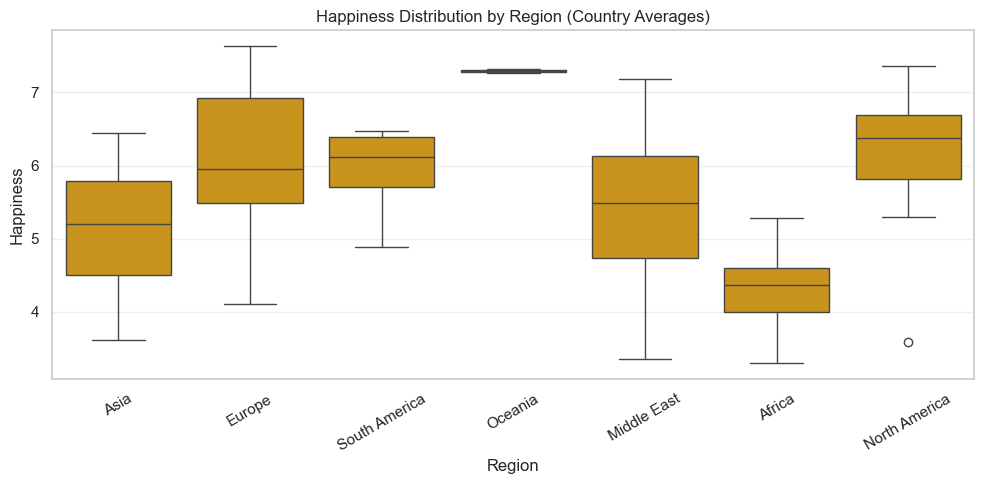

In [58]:
plt.figure(figsize=(10, 5))

sns.boxplot(
    data=df_country,
    x="Region",
    y="Happiness"
)

plt.title("Happiness Distribution by Region (Country Averages)")
plt.xlabel("Region")
plt.ylabel("Happiness")
plt.xticks(rotation=30)
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

This comparison provides a baseline view of regional differences in reported happiness, highlighting variation in both central tendency and spread across regions. These observed differences motivate further analysis to determine whether such patterns persist after accounting for underlying economic and social conditions.


#### RQ1 – Step 2: Establishing a Structural Baseline

To assess whether regional differences in happiness persist beyond economic and social conditions, a shared structural baseline is required. Based on the multivariate analysis, the first principal component (PC1) captures the dominant socio-economic dimension of the data, primarily reflecting GDP, health, and social support.

In this step, PC1 is used as a proxy for overall structural conditions at the country level.


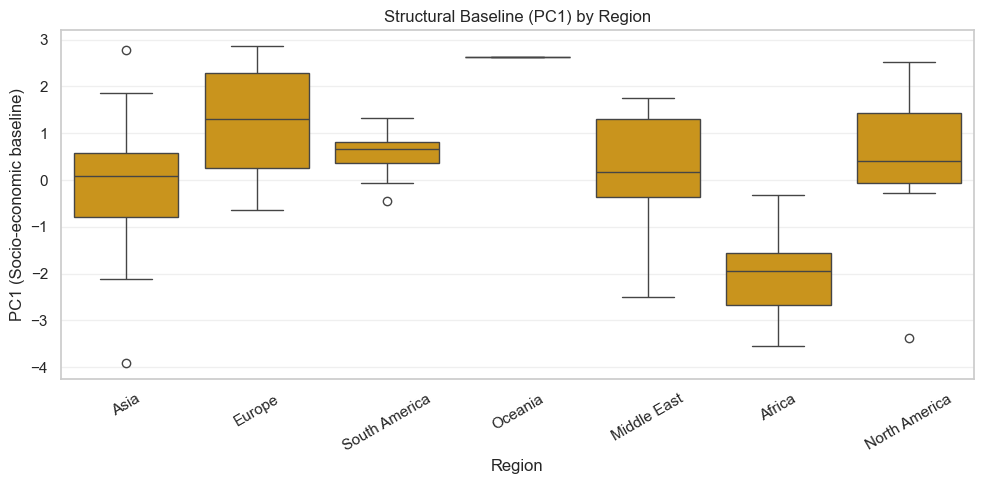

In [59]:
# Create country-level dataframe for PCA
df_pca_country = (
    df_balanced
    .groupby(["Country", "Region"], as_index=False)[
        ["GDP", "SocialSupport", "Health", "Freedom", "Generosity"]
    ]
    .mean()
)

# Drop countries with remaining missing values (PCA-only)
df_pca_country = df_pca_country.dropna()

# Standardise
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = df_pca_country[
    ["GDP", "SocialSupport", "Health", "Freedom", "Generosity"]
]

X_scaled = StandardScaler().fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Attach PC1
df_pca_country["PC1"] = X_pca[:, 0]


plt.figure(figsize=(10, 5))

sns.boxplot(
    data=df_pca_country,
    x="Region",
    y="PC1"
)

plt.title("Structural Baseline (PC1) by Region")
plt.xlabel("Region")
plt.ylabel("PC1 (Socio-economic baseline)")
plt.xticks(rotation=30)
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


This plot shows how regions differ in their overall socio-economic conditions as summarised by PC1. Establishing this baseline is necessary before assessing whether regional differences in happiness remain after accounting for structure.


#### RQ1 – Step 3: Happiness Relative to the Structural Baseline

For countries with similar structural conditions, do regions still report different happiness levels?

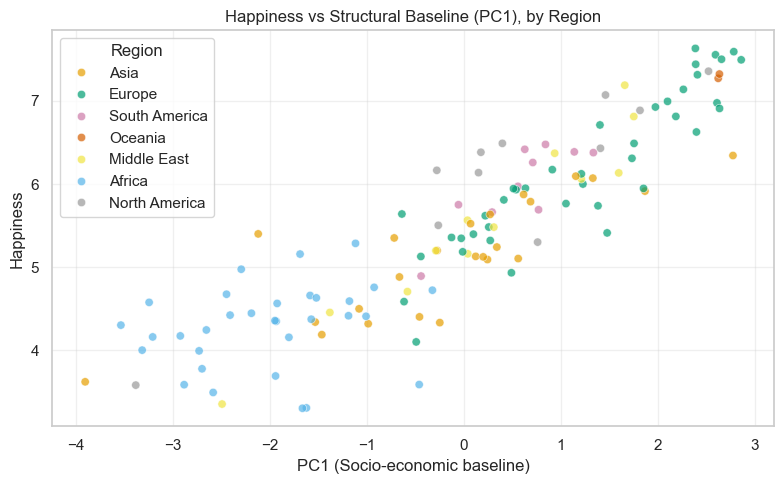

In [60]:
df_rq1 = (
    df_country
    .merge(
        df_pca_country[["Country", "PC1"]],
        on="Country",
        how="inner"
    )
)

plt.figure(figsize=(8, 5))

sns.scatterplot(
    data=df_rq1,
    x="PC1",
    y="Happiness",
    hue="Region",
    alpha=0.7
)

plt.title("Happiness vs Structural Baseline (PC1), by Region")
plt.xlabel("PC1 (Socio-economic baseline)")
plt.ylabel("Happiness")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### RQ1 Conclusion

The analysis shows that countries within similar regional contexts exhibit comparable happiness reporting patterns, and that these patterns differ systematically across regions. While the structural baseline captured by PC1 explains a substantial portion of variation in happiness, regional differences remain visible among countries with similar socio-economic conditions. This indicates that regional context contributes to happiness reporting beyond what is explained by economic and social indicators alone.
